In [1]:
from typing import Callable

import numpy as np
import pandas as pd
import scipy.constants as consts
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import patheffects, patches

%matplotlib widget

In [2]:
# Define constants
RHO = 1.225  # kg / m^3

# Define requirements
v_cruise_low = 30. * consts.knot
v_cruise_mid = 45. * consts.knot
v_cruise_high = 60. * consts.knot
v_stall = 8. * consts.knot
r_turn = 200 * consts.foot
climb_rate = 400 * consts.foot / consts.minute
altitude = 200 * consts.foot

lap_straight = 600 * consts.foot
num_laps = 3
max_GLOM = 15 * consts.lb
max_wingspan = 5 * consts.foot

# Define assumptions
v_turn_low = v_cruise_low * 0.9
v_climb_low = v_cruise_low * 0.7
v_turn_mid = v_cruise_mid * 0.8
v_climb_mid = v_cruise_mid * 0.6
v_turn_high = v_cruise_high * 0.7
v_climb_high = v_cruise_high * 0.5

CLIMB_L_D_SCALE = 0.866
TURN_L_D_SCALE = 0.95
BATTERY_MARGIN = 1.5

# Conservative
CL_max_conserv = 1.2
CD_0_conserv = 0.05
eta_prop_conserv = 0.6
L_D_max_conserv = 6
AR_conserv = 5
e_oswald_conserv = 0.70
k_conserv = 1 / (np.pi * AR_conserv * e_oswald_conserv)
eta_motor_conserv = 0.7
enrg_density_conserv = 150 * consts.hour

# Aggressive
CL_max_aggr = 1.8
CD_0_aggr = 0.025
eta_prop_aggr = 0.85
L_D_max_aggr = 12
AR_aggr = 8
e_oswald_aggr = 0.85
k_aggr = 1 / (np.pi * AR_aggr * e_oswald_aggr)
eta_motor_aggr = 0.9
enrg_density_aggr = 250 * consts.hour

# Derived values
climb_angle_low = np.asin(climb_rate / v_climb_low)
load_factor_low = np.sqrt((v_turn_low**2 / r_turn / consts.g)**2 + 1)
bank_angle_low = np.acos(1 / load_factor_low)

climb_angle_mid = np.asin(climb_rate / v_climb_mid)
load_factor_mid = np.sqrt((v_turn_mid**2 / r_turn / consts.g)**2 + 1)
bank_angle_mid = np.acos(1 / load_factor_mid)

climb_angle_high = np.asin(climb_rate / v_climb_high)
load_factor_high = np.sqrt((v_turn_high**2 / r_turn / consts.g)**2 + 1)
bank_angle_high = np.acos(1 / load_factor_high)

print(f"Climb angle (low speed)       = {np.rad2deg(climb_angle_low):.2f}°")
print(f"Turn load factor (low speed)  = {load_factor_low:.3f}")
print(f"Turn bank angle (low speed)   = {np.rad2deg(bank_angle_low):.1f}°")
print()
print(f"Climb angle (mid speed)       = {np.rad2deg(climb_angle_mid):.2f}°")
print(f"Turn load factor (mid speed)  = {load_factor_mid:.3f}")
print(f"Turn bank angle (mid speed)   = {np.rad2deg(bank_angle_mid):.1f}°")
print()
print(f"Climb angle (high speed)      = {np.rad2deg(climb_angle_high):.2f}°")
print(f"Turn load factor (high speed) = {load_factor_high:.3f}")
print(f"Turn bank angle (high speed)  = {np.rad2deg(bank_angle_high):.1f}°")

Climb angle (low speed)       = 10.84°
Turn load factor (low speed)  = 1.051
Turn bank angle (low speed)   = 17.9°

Climb angle (mid speed)       = 8.41°
Turn load factor (mid speed)  = 1.153
Turn bank angle (mid speed)   = 29.8°

Climb angle (high speed)      = 7.57°
Turn load factor (high speed) = 1.269
Turn bank angle (high speed)  = 38.0°


In [3]:
def mk_stall_cond_func(
    CL_max: float, vs: float, rho: float = RHO
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make stall condition constraint function.

    :param float CL_max: Maximum lift coefficient
    :param float vs: Stall true airspeed
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (CL_max * rho * vs**2 * 0.5) - ws

    return f

In [4]:
def mk_cruise_cond_func(
    vc: float, CD_0: float, eta_p: float, rho: float = RHO, CD_scale: float = 1.1
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vc: Cruise true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float rho: (optional) Atmospheric density
    :param float CD_scale: (optional) Scale factor for total drag (including induced drag)
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p * 2.) / (rho * vc**3 * CD_scale * CD_0) * ws - wp

    return f

In [5]:
def mk_climb_cond_func(
    vcl: float, gamma: float, eta_p: float, L_D_max: float, L_D_scale: float = CLIMB_L_D_SCALE
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vcl: Climb true airspeed
    :param float gamma: Climb rate
    :param float eta_p: Propeller efficiency
    :param float L_D_max: Maximum lift-to-drag ratio L/D
    :param float L_D_scale: (optional) Scale factor for L/D ration during climb
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return eta_p / vcl / (gamma + 1 / (L_D_max * L_D_scale)) - wp

    return f

In [6]:
def mk_turn_cond_func(
    vtr: float, CD_0: float, eta_p: float, n: float, k: float, rho: float = RHO,
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vtr: Turn true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float n: Turn load factor
    :param float k: Induced drag factor 1 / π AR e
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """
    
    q = 0.5 * rho * vtr**2

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p / q / vtr / (k * (n / q)**2 * ws + CD_0 / ws)) - wp

    return f

In [7]:
# Conservative constraints, low speed
stall_f_conserv_low = mk_stall_cond_func(CL_max_conserv, v_stall)
cruise_f_conserv_low = mk_cruise_cond_func(v_cruise_low, CD_0_conserv, eta_prop_conserv)
climb_f_conserv_low = mk_climb_cond_func(v_climb_low, climb_angle_low, eta_prop_conserv, L_D_max_conserv)
turn_f_conserv_low = mk_turn_cond_func(v_turn_low, CD_0_conserv, eta_prop_conserv, load_factor_low, k_conserv)

# Agressive constraints, low speed
stall_f_aggr_low = mk_stall_cond_func(CL_max_aggr, v_stall)
cruise_f_aggr_low = mk_cruise_cond_func(v_cruise_low, CD_0_aggr, eta_prop_aggr)
climb_f_aggr_low = mk_climb_cond_func(v_climb_low, climb_angle_low, eta_prop_aggr, L_D_max_aggr)
turn_f_aggr_low = mk_turn_cond_func(v_turn_low, CD_0_aggr, eta_prop_aggr, load_factor_low, k_aggr)

In [8]:
# Conservative constraints, mid speed
stall_f_conserv_mid = mk_stall_cond_func(CL_max_conserv, v_stall)
cruise_f_conserv_mid = mk_cruise_cond_func(v_cruise_mid, CD_0_conserv, eta_prop_conserv)
climb_f_conserv_mid = mk_climb_cond_func(v_climb_mid, climb_angle_mid, eta_prop_conserv, L_D_max_conserv)
turn_f_conserv_mid = mk_turn_cond_func(v_turn_mid, CD_0_conserv, eta_prop_conserv, load_factor_mid, k_conserv)

# Agressive constraints, mid speed
stall_f_aggr_mid = mk_stall_cond_func(CL_max_aggr, v_stall)
cruise_f_aggr_mid = mk_cruise_cond_func(v_cruise_mid, CD_0_aggr, eta_prop_aggr)
climb_f_aggr_mid = mk_climb_cond_func(v_climb_mid, climb_angle_mid, eta_prop_aggr, L_D_max_aggr)
turn_f_aggr_mid = mk_turn_cond_func(v_turn_mid, CD_0_aggr, eta_prop_aggr, load_factor_mid, k_aggr)

In [9]:
# Conservative constraints, high speed
stall_f_conserv_high = mk_stall_cond_func(CL_max_conserv, v_stall)
cruise_f_conserv_high = mk_cruise_cond_func(v_cruise_high, CD_0_conserv, eta_prop_conserv)
climb_f_conserv_high = mk_climb_cond_func(v_climb_high, climb_angle_high, eta_prop_conserv, L_D_max_conserv)
turn_f_conserv_high = mk_turn_cond_func(v_turn_high, CD_0_conserv, eta_prop_conserv, load_factor_high, k_conserv)

# Agressive constraints, high speed
stall_f_aggr_high = mk_stall_cond_func(CL_max_aggr, v_stall)
cruise_f_aggr_high = mk_cruise_cond_func(v_cruise_high, CD_0_aggr, eta_prop_aggr)
climb_f_aggr_high = mk_climb_cond_func(v_climb_high, climb_angle_high, eta_prop_aggr, L_D_max_aggr)
turn_f_aggr_high = mk_turn_cond_func(v_turn_high, CD_0_aggr, eta_prop_aggr, load_factor_high, k_aggr)

In [10]:
# Constraint domain
min_wing_loading = 2.9 * consts.g  # Ozone Buzz Z3 MS (paraglider)
max_wing_loading = 837 * consts.g  # McDonnel Douglas MD-11 (widebody airliner)
min_power_loading = 1 / (634 / consts.g)  # Supermarine S.6B (racing aircraft)
max_power_loading = 1 / (106 / consts.g)  # Boeing B-29 (heavy bomber)

ws_lo = np.floor(np.log10(min_wing_loading))
ws_hi = np.ceil(np.log10(max_wing_loading))
wp_lo = np.floor(np.log10(min_power_loading)) - 1
wp_hi = np.ceil(np.log10(max_power_loading)) + 1

ws = np.logspace(ws_lo, ws_hi)  # Wing loading N/m^2
wp = np.logspace(wp_lo, wp_hi)  # Power loading N/W

ws, wp = np.meshgrid(ws, wp)

min_wing_loading / (consts.lbf / consts.foot**2), max_wing_loading / (consts.lbf / consts.foot**2), min_power_loading / (consts.lbf / consts.horsepower), max_power_loading / (consts.lbf / consts.horsepower)

(0.5939668165053127, 171.4311122120506, 2.593039126182965, 15.509309490566034)

In [11]:
# Wing and power loading cost function for optimization
def cost_fn(x: np.ndarray):
    ws, wp = x
    
    return -ws - wp

# Constraint functions converted for optimization
constrs_low = (
    {'type': 'ineq', 'fun': lambda x: stall_f_conserv_low(*x)},
    {'type': 'ineq', 'fun': lambda x: cruise_f_conserv_low(*x)},
    {'type': 'ineq', 'fun': lambda x: climb_f_conserv_low(*x)},
    {'type': 'ineq', 'fun': lambda x: turn_f_conserv_low(*x)},
)
constrs_mid = (
    {'type': 'ineq', 'fun': lambda x: stall_f_conserv_mid(*x)},
    {'type': 'ineq', 'fun': lambda x: cruise_f_conserv_mid(*x)},
    {'type': 'ineq', 'fun': lambda x: climb_f_conserv_mid(*x)},
    {'type': 'ineq', 'fun': lambda x: turn_f_conserv_mid(*x)},
)
constrs_high = (
    {'type': 'ineq', 'fun': lambda x: stall_f_conserv_high(*x)},
    {'type': 'ineq', 'fun': lambda x: cruise_f_conserv_high(*x)},
    {'type': 'ineq', 'fun': lambda x: climb_f_conserv_high(*x)},
    {'type': 'ineq', 'fun': lambda x: turn_f_conserv_high(*x)},
)

# Bounds on solver space
bnds = ((10**ws_lo, 10**ws_hi), (10**wp_lo, 10**wp_hi))

optim_res_low = minimize(cost_fn, (10**ws_lo, 10**wp_lo), bounds=bnds, constraints=constrs_low)
optim_res_mid = minimize(cost_fn, (10**ws_lo, 10**wp_lo), bounds=bnds, constraints=constrs_mid)
optim_res_high = minimize(cost_fn, (10**ws_lo, 10**wp_lo), bounds=bnds, constraints=constrs_high)

ws_optim_low, wp_optim_low = optim_res_low.x
ws_optim_mid, wp_optim_mid = optim_res_mid.x
ws_optim_high, wp_optim_high = optim_res_high.x

optim_res_low, optim_res_mid, optim_res_high

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: -12.509599269276896
        x: [ 1.245e+01  6.032e-02]
      nit: 3
      jac: [-1.000e+00 -1.000e+00]
     nfev: 9
     njev: 3,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: -12.467153209726979
        x: [ 1.245e+01  1.787e-02]
      nit: 3
      jac: [-1.000e+00 -1.000e+00]
     nfev: 9
     njev: 3,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: -12.456820945696805
        x: [ 1.245e+01  7.540e-03]
      nit: 3
      jac: [-1.000e+00 -1.000e+00]
     nfev: 9
     njev: 3)

In [12]:
stall_conserv_low = stall_f_conserv_low(ws, wp)
cruise_conserv_low = cruise_f_conserv_low(ws, wp)
climb_conserv_low = climb_f_conserv_low(ws, wp)
turn_conserv_low = turn_f_conserv_low(ws, wp)

stall_aggr_low = stall_f_aggr_low(ws, wp)
cruise_aggr_low = cruise_f_aggr_low(ws, wp)
climb_aggr_low = climb_f_aggr_low(ws, wp)
turn_aggr_low = turn_f_aggr_low(ws, wp)

In [13]:
stall_conserv_mid = stall_f_conserv_mid(ws, wp)
cruise_conserv_mid = cruise_f_conserv_mid(ws, wp)
climb_conserv_mid = climb_f_conserv_mid(ws, wp)
turn_conserv_mid = turn_f_conserv_mid(ws, wp)

stall_aggr_mid = stall_f_aggr_mid(ws, wp)
cruise_aggr_mid = cruise_f_aggr_mid(ws, wp)
climb_aggr_mid = climb_f_aggr_mid(ws, wp)
turn_aggr_mid = turn_f_aggr_mid(ws, wp)

In [14]:
stall_conserv_high = stall_f_conserv_high(ws, wp)
cruise_conserv_high = cruise_f_conserv_high(ws, wp)
climb_conserv_high = climb_f_conserv_high(ws, wp)
turn_conserv_high = turn_f_conserv_high(ws, wp)

stall_aggr_high = stall_f_aggr_high(ws, wp)
cruise_aggr_high = cruise_f_aggr_high(ws, wp)
climb_aggr_high = climb_f_aggr_high(ws, wp)
turn_aggr_high = turn_f_aggr_high(ws, wp)

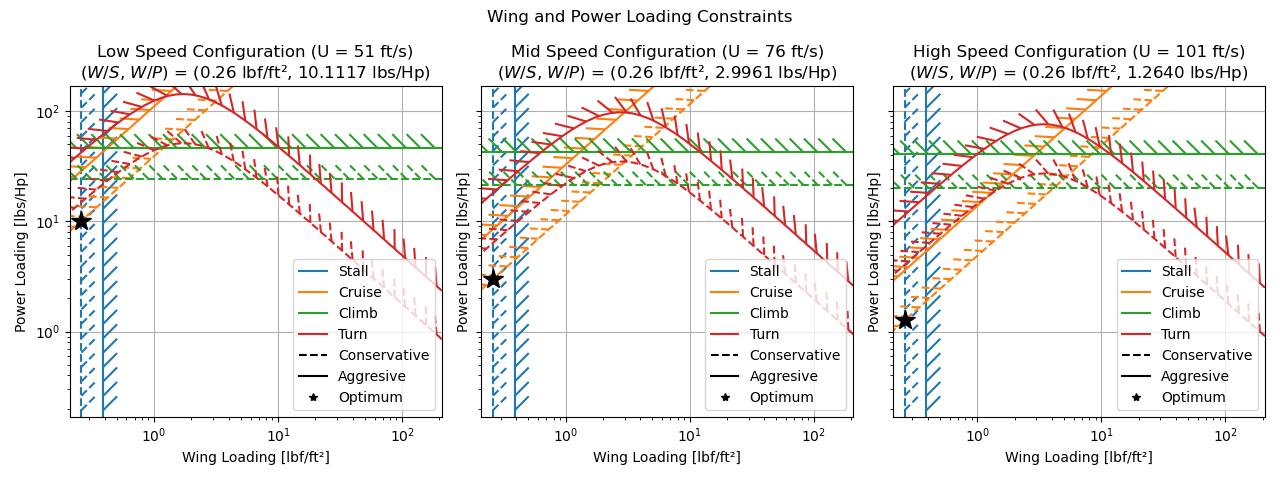

In [15]:
fig, ax = plt.subplots(1,3, figsize=(12.8, 4.8), sharex=True, sharey=True)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ws2 = ws / (consts.lbf / consts.foot**2)
wp2 = wp / (consts.lbf / consts.horsepower)

# Low
stall_cntr_conserv_low = ax[0].contour(ws2, wp2, stall_conserv_low, [0], colors="C0", linestyles="--")
stall_cntr_conserv_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
stall_cntr_aggr_low = ax[0].contour(ws2, wp2, stall_aggr_low, [0], colors="C0", linestyles="-")
stall_cntr_aggr_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

cruise_cntr_conserv_low = ax[0].contour(ws2, wp2, cruise_conserv_low, [0], colors="C1", linestyles="--")
cruise_cntr_conserv_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
cruise_cntr_aggr_low = ax[0].contour(ws2, wp2, cruise_aggr_low, [0], colors="C1", linestyles="-")
cruise_cntr_aggr_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

climb_cntr_conserv_low = ax[0].contour(ws2, wp2, climb_conserv_low, [0], colors="C2", linestyles="--")
climb_cntr_conserv_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
climb_cntr_aggr_low = ax[0].contour(ws2, wp2, climb_aggr_low, [0], colors="C2", linestyles="-")
climb_cntr_aggr_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

turn_cntr_conserv_low = ax[0].contour(ws2, wp2, turn_conserv_low, [0], colors="C3", linestyles="--")
turn_cntr_conserv_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
turn_cntr_aggr_low = ax[0].contour(ws2, wp2, turn_aggr_low, [0], colors="C3", linestyles="-")
turn_cntr_aggr_low.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

# Mid
stall_cntr_conserv_mid = ax[1].contour(ws2, wp2, stall_conserv_mid, [0], colors="C0", linestyles="--")
stall_cntr_conserv_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
stall_cntr_aggr_mid = ax[1].contour(ws2, wp2, stall_aggr_mid, [0], colors="C0", linestyles="-")
stall_cntr_aggr_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

cruise_cntr_conserv_mid = ax[1].contour(ws2, wp2, cruise_conserv_mid, [0], colors="C1", linestyles="--")
cruise_cntr_conserv_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
cruise_cntr_aggr_mid = ax[1].contour(ws2, wp2, cruise_aggr_mid, [0], colors="C1", linestyles="-")
cruise_cntr_aggr_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

climb_cntr_conserv_mid = ax[1].contour(ws2, wp2, climb_conserv_mid, [0], colors="C2", linestyles="--")
climb_cntr_conserv_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
climb_cntr_aggr_mid = ax[1].contour(ws2, wp2, climb_aggr_mid, [0], colors="C2", linestyles="-")
climb_cntr_aggr_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

turn_cntr_conserv_mid = ax[1].contour(ws2, wp2, turn_conserv_mid, [0], colors="C3", linestyles="--")
turn_cntr_conserv_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
turn_cntr_aggr_mid = ax[1].contour(ws2, wp2, turn_aggr_mid, [0], colors="C3", linestyles="-")
turn_cntr_aggr_mid.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

# High
stall_cntr_conserv_high = ax[2].contour(ws2, wp2, stall_conserv_high, [0], colors="C0", linestyles="--")
stall_cntr_conserv_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
stall_cntr_aggr_high = ax[2].contour(ws2, wp2, stall_aggr_high, [0], colors="C0", linestyles="-")
stall_cntr_aggr_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

cruise_cntr_conserv_high = ax[2].contour(ws2, wp2, cruise_conserv_high, [0], colors="C1", linestyles="--")
cruise_cntr_conserv_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
cruise_cntr_aggr_high = ax[2].contour(ws2, wp2, cruise_aggr_high, [0], colors="C1", linestyles="-")
cruise_cntr_aggr_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

climb_cntr_conserv_high = ax[2].contour(ws2, wp2, climb_conserv_high, [0], colors="C2", linestyles="--")
climb_cntr_conserv_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
climb_cntr_aggr_high = ax[2].contour(ws2, wp2, climb_aggr_high, [0], colors="C2", linestyles="-")
climb_cntr_aggr_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

turn_cntr_conserv_high = ax[2].contour(ws2, wp2, turn_conserv_high, [0], colors="C3", linestyles="--")
turn_cntr_conserv_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
turn_cntr_aggr_high = ax[2].contour(ws2, wp2, turn_aggr_high, [0], colors="C3", linestyles="-")
turn_cntr_aggr_high.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

ax[0].plot(ws_optim_low / (consts.lbf / consts.foot**2), wp_optim_low / (consts.lbf / consts.horsepower), '*k', markersize=15)
ax[1].plot(ws_optim_mid / (consts.lbf / consts.foot**2), wp_optim_mid / (consts.lbf / consts.horsepower), '*k', markersize=15)
ax[2].plot(ws_optim_high / (consts.lbf / consts.foot**2), wp_optim_high / (consts.lbf / consts.horsepower), '*k', markersize=15)

ax[0].set_xlabel("Wing Loading [lbf/ft²]")
ax[0].set_ylabel("Power Loading [lbs/Hp]")
ax[1].set_xlabel("Wing Loading [lbf/ft²]")
ax[1].set_ylabel("Power Loading [lbs/Hp]")
ax[2].set_xlabel("Wing Loading [lbf/ft²]")
ax[2].set_ylabel("Power Loading [lbs/Hp]")
legend_lines = [
    plt.Line2D([], [], color='C0', label="Stall"),
    plt.Line2D([], [], color='C1', label="Cruise"),
    plt.Line2D([], [], color='C2', label="Climb"),
    plt.Line2D([], [], color='C3', label="Turn"),
    plt.Line2D([], [], color='k', linestyle='--', label="Conservative"),
    plt.Line2D([], [], color='k', label="Aggresive"),
    plt.Line2D([], [], color='k', linestyle='', marker='*', label="Optimum"),
]
ax[0].legend(handles=legend_lines, loc="lower right")
ax[1].legend(handles=legend_lines, loc="lower right")
ax[2].legend(handles=legend_lines, loc="lower right")
ax[0].set_title(f"Low Speed Configuration (U = {v_cruise_low / consts.foot:.0f} ft/s)\n($W/S$, $W/P$) = ({ws_optim_low / (consts.lbf / consts.foot**2):.2f} lbf/ft², {wp_optim_low / (consts.lbf / consts.horsepower):.4f} lbs/Hp)")
ax[1].set_title(f"Mid Speed Configuration (U = {v_cruise_mid / consts.foot:.0f} ft/s)\n($W/S$, $W/P$) = ({ws_optim_mid / (consts.lbf / consts.foot**2):.2f} lbf/ft², {wp_optim_mid / (consts.lbf / consts.horsepower):.4f} lbs/Hp)")
ax[2].set_title(f"High Speed Configuration (U = {v_cruise_high / consts.foot:.0f} ft/s)\n($W/S$, $W/P$) = ({ws_optim_high / (consts.lbf / consts.foot**2):.2f} lbf/ft², {wp_optim_high / (consts.lbf / consts.horsepower):.4f} lbs/Hp)")
fig.suptitle("Wing and Power Loading Constraints")
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.tight_layout()
fig.savefig("Loading.png", dpi=300)

array([0.19717912, 0.13343333])

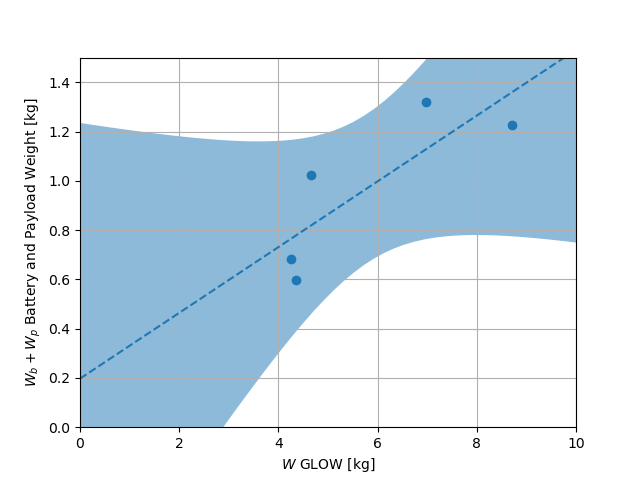

In [16]:
# Class historical W, Wp_Wb data (digitized from plot)
m_data = np.array([9.57912457912458, 9.393939393939394, 10.286195286195285, 15.387205387205388, 19.19191919191919]) * consts.lb
mp_mb_data= np.array([1.3171378091872792, 1.5026501766784452, 2.2570671378091873, 2.9125441696113072, 2.7022968197879855]) * consts.lb

X = sm.add_constant(m_data)
ols_model = sm.OLS(mp_mb_data, X)
est = ols_model.fit()

m_range = np.linspace(0, 10)
X2 = sm.add_constant(m_range)
pred = est.get_prediction(X2).summary_frame()

fig, ax = plt.subplots(1,1)
ax.plot(m_data, mp_mb_data, 'o')
ax.fill_between(m_range, pred['mean_ci_lower'], pred['mean_ci_upper'], alpha=0.5)
ax.plot(m_range, pred['mean'], "C0--")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.5)
ax.set_xlabel("$W$ GLOW [kg]")
ax.set_ylabel("$W_b + W_p$ Battery and Payload Weight [kg]")
ax.grid()

est.params

In [17]:
def predict_specific_energy_level_flight(dist: float, L_D_cruise: float) -> float:
    """
    Predict the specific energy consumed during level flight

    :param float dist: Level flight distance range
    :param float L_D_cruise: L/D lift to drag ratio in level flight
    :return float: Specific energy consumption E/m
    """

    return dist * consts.g / L_D_cruise

In [18]:
def predict_specific_energy_turn_flight(
    dist: float, L_D_turn: float, load_factor: float
) -> float:
    """
    Predict the specific energy consumed during turning flight

    :param float dist: Turning flight distance range
    :param float L_D_turn: L/D lift to drag ratio in level flight
    :param float load_factor: Turn load factor
    :return float: Specific energy consumption E/m
    """

    return dist * consts.g * load_factor / L_D_turn

In [19]:
def predict_specific_energy_climb(
    altitude: float, L_D_climb: float, climb_angle: float
) -> float:
    """
    Predict the specific energy consumed during climb phase

    :param float altitude: Total altitude of climb
    :param float L_D_climb: L/D lift to drag ratio in level flight
    :param float climb_angle: Angle of climb
    :return float: Specific energy consumption E/m
    """

    return altitude * consts.g * (1 + 1 / (np.tan(climb_angle) * L_D_climb))

In [20]:
def predict_specific_energy_total(
    dist_straight: float,
    turn_radius: float,
    climb_alt: float,
    L_D_max: float,
    load_factor: float,
    climb_angle: float,
    cruise_speed: float,
    turn_speed: float,
    climb_rate: float,
    num_laps: int = 1,
    L_D_factor_turn: float = TURN_L_D_SCALE,
    L_D_factor_climb: float = CLIMB_L_D_SCALE,
):
    """
    Predict the specific energy consumed during a mission and report a the
    the breakdowns. Assumes an oval racetrack path with a straightaway distance
    of `dist_straight` and semicircular caps with radius `turn_radius`, for a
    total oval length of `2 * dist_straight + 2*pi * turn_radius`. This is
    repeated `num_laps` times. A climb at `climb_angle` to an altitude of
    `climb_alt` preceedes the laps.

    :param float dist_straight: Straightaway distance of one half lap
    :param float turn_radius: Turn radius of lap
    :param float climb_alt: Altitude to climb to
    :param float L_D_max: Maximum lift-to-drag ratio L/D of aircraft
    :param float load_factor: Turn load factor
    :param float climb_angle: Climb rate angle
    :param float cruise_speed: Cruising speed for timing estimation
    :param float turn_speed: Turning speed for timing estimation
    :param float climb_rate: Climb vertical rate for timing estimation
    :param float num_laps: (optional) Number of laps in mission
    :param float L_D_factor_turn: (optional) Scale factor for L/D ration during turn
    :param float L_D_factor_climb: (optional) Scale factor for L/D ration during climb
    """

    lap_straight = 2 * dist_straight
    lap_turn = 2 * np.pi * turn_radius
    lap_total = lap_straight + lap_turn

    total_straight = lap_straight * num_laps
    total_turn = lap_turn * num_laps
    total_range = total_straight + total_turn

    L_D_straight = L_D_max
    L_D_turn = L_D_max * L_D_factor_turn
    L_D_climb = L_D_max * L_D_factor_climb

    e_straight_lap = predict_specific_energy_level_flight(lap_straight, L_D_straight)
    e_turn_lap = predict_specific_energy_turn_flight(lap_turn, L_D_turn, load_factor)
    e_lap = e_straight_lap + e_turn_lap
    
    e_straight_total = predict_specific_energy_level_flight(total_straight, L_D_straight)
    e_turn_total = predict_specific_energy_turn_flight(total_turn, L_D_turn, load_factor)
    e_total_laps = e_straight_total + e_turn_total
    
    e_climb = predict_specific_energy_climb(climb_alt, L_D_climb, climb_angle)
    
    e_total = e_climb + e_total_laps
    
    t_climb = climb_alt / climb_rate
    t_lap_straight = lap_straight / cruise_speed
    t_lap_turn = lap_turn / cruise_speed
    t_lap_total = t_lap_straight + t_lap_turn
    t_laps_total = t_lap_total * num_laps
    t_total = t_laps_total + t_climb*2

    return e_total, {
        "e_total": e_total,
        "e_climb": e_climb,
        "e_total_laps": e_total_laps,
        "e_straight_total": e_straight_total,
        "e_turn_total": e_turn_total,
        "e_lap": e_lap,
        "e_straight_lap": e_straight_lap,
        "e_turn_lap": e_turn_lap,
        "range_total": total_range,
        "range_straight": total_straight,
        "range_turn": total_turn,
        "range_lap": lap_total,
        "range_lap_straight": lap_straight,
        "range_lap_turn": lap_turn,
        "climb_alt": climb_alt,
        "L_D_straight": L_D_straight,
        "L_D_turn": L_D_turn,
        "L_D_climb": L_D_climb,
        "t_climb": t_climb,
        "t_lap_straight": t_lap_straight,
        "t_lap_turn": t_lap_turn,
        "t_lap_total": t_laps_total,
        "t_laps_total": t_laps_total,
        "t_total": t_total,
    }

In [21]:
e_total_conserv_low, data_conserv_low = predict_specific_energy_total(
    lap_straight,
    r_turn,
    altitude,
    L_D_max_conserv,
    load_factor_low,
    climb_angle_low,
    v_cruise_low,
    v_turn_low,
    climb_rate,
    num_laps,
)
e_total_aggr_low, data_aggr_low = predict_specific_energy_total(
    lap_straight,
    r_turn,
    altitude,
    L_D_max_aggr,
    load_factor_low,
    climb_angle_low,
    v_cruise_low,
    v_turn_low,
    climb_rate,
    num_laps,
)

e_total_conserv_mid, data_conserv_mid = predict_specific_energy_total(
    lap_straight,
    r_turn,
    altitude,
    L_D_max_conserv,
    load_factor_mid,
    climb_angle_mid,
    v_cruise_mid,
    v_turn_mid,
    climb_rate,
    num_laps,
)
e_total_aggr_mid, data_aggr_mid = predict_specific_energy_total(
    lap_straight,
    r_turn,
    altitude,
    L_D_max_aggr,
    load_factor_mid,
    climb_angle_mid,
    v_cruise_mid,
    v_turn_mid,
    climb_rate,
    num_laps,
)

e_total_conserv_high, data_conserv_high = predict_specific_energy_total(
    lap_straight,
    r_turn,
    altitude,
    L_D_max_conserv,
    load_factor_high,
    climb_angle_high,
    v_cruise_high,
    v_turn_high,
    climb_rate,
    num_laps,
)
e_total_aggr_high, data_aggr_high = predict_specific_energy_total(
    lap_straight,
    r_turn,
    altitude,
    L_D_max_aggr,
    load_factor_high,
    climb_angle_high,
    v_cruise_high,
    v_turn_high,
    climb_rate,
    num_laps,
)

pd.DataFrame(
    [
        data_conserv_low,
        data_aggr_low,
        data_conserv_mid,
        data_aggr_mid,
        data_conserv_high,
        data_aggr_high,
    ],
    index=[
        "Conservative (low)",
        "Aggressive (low)",
        "Conservative (mid)",
        "Aggressive (mid)",
        "Conservative (high)",
        "Aggressive (high)",
    ],
)

,e_total,e_climb,e_total_laps,e_straight_total,e_turn_total,e_lap,e_straight_lap,e_turn_lap,range_total,range_straight,...,climb_alt,L_D_straight,L_D_turn,L_D_climb,t_climb,t_lap_straight,t_lap_turn,t_lap_total,t_laps_total,t_total
Conservative (low),5069.361125,1198.584676,3870.776449,1793.440152,2077.336297,1290.258816,597.813384,692.445432,2246.348929,1097.28,...,60.96,6,5.7,5.196,30.0,23.699352,24.817903,145.551766,145.551766,205.551766
Aggressive (low),2833.587254,898.199030,1935.388224,896.720076,1038.668148,645.129408,298.906692,346.222716,2246.348929,1097.28,...,60.96,12,11.4,10.392,30.0,23.699352,24.817903,145.551766,145.551766,205.551766
Conservative (mid),5448.456110,1375.809306,4072.646804,1793.440152,2279.206652,1357.548935,597.813384,759.735551,2246.348929,1097.28,...,60.96,6,5.7,5.196,30.0,15.799568,16.545269,97.034511,97.034511,157.034511
Aggressive (mid),3023.134747,986.811345,2036.323402,896.720076,1139.603326,678.774467,298.906692,379.867775,2246.348929,1097.28,...,60.96,12,11.4,10.392,30.0,15.799568,16.545269,97.034511,97.034511,157.034511
Conservative (high),5765.813662,1464.047396,4301.766266,1793.440152,2508.326114,1433.922089,597.813384,836.108705,2246.348929,1097.28,...,60.96,6,5.7,5.196,30.0,11.849676,12.408952,72.775883,72.775883,132.775883
Aggressive (high),3181.813523,1030.930390,2150.883133,896.720076,1254.163057,716.961044,298.906692,418.054352,2246.348929,1097.28,...,60.96,12,11.4,10.392,30.0,11.849676,12.408952,72.775883,72.775883,132.775883


In [22]:
def estimate_battery_mass_fraction_props(
    e_total: float,
    eta_prop: float,
    eta_motor: float,
    battery_e_density: float,
    margin: float,
):
    """
    Estimate the battery mass fraction from other parameters.

    :param float e_total: Mission specific energy total
    :param float eta_prop: Propeller efficiency
    :param float eta_motor: Motor efficiency
    :param float battery_e_density: Battery energy density
    :param float margin: Energy margin
    """

    e_batt = e_total * margin / (eta_prop * eta_motor)
    mb_m = e_batt / battery_e_density

    return mb_m, {
        "mb/m": mb_m,
        "mission specific energy": e_total,
        "specific energy with margin": e_total * margin,
        "battery specific energy": e_batt,
    }

In [23]:
mb_m_conserv_low, bat_props_conserv_low = estimate_battery_mass_fraction_props(
    e_total_conserv_low, eta_prop_conserv, eta_motor_conserv, enrg_density_conserv, BATTERY_MARGIN + 1.
)
mb_m_aggr_low, bat_props_aggr_low = estimate_battery_mass_fraction_props(
    e_total_aggr_low, eta_prop_aggr, eta_motor_aggr, enrg_density_aggr, BATTERY_MARGIN + 1.
)

mb_m_conserv_mid, bat_props_conserv_mid = estimate_battery_mass_fraction_props(
    e_total_conserv_mid, eta_prop_conserv, eta_motor_conserv, enrg_density_conserv, BATTERY_MARGIN + 1.
)
mb_m_aggr_mid, bat_props_aggr_mid = estimate_battery_mass_fraction_props(
    e_total_aggr_mid, eta_prop_aggr, eta_motor_aggr, enrg_density_aggr, BATTERY_MARGIN + 1.
)

mb_m_conserv_high, bat_props_conserv_high = estimate_battery_mass_fraction_props(
    e_total_conserv_high, eta_prop_conserv, eta_motor_conserv, enrg_density_conserv, BATTERY_MARGIN + 1.
)
mb_m_aggr_high, bat_props_aggr_high = estimate_battery_mass_fraction_props(
    e_total_aggr_high, eta_prop_aggr, eta_motor_aggr, enrg_density_aggr, BATTERY_MARGIN + 1.
)

pd.DataFrame(
    [
        bat_props_conserv_low,
        bat_props_aggr_low,
        bat_props_conserv_mid,
        bat_props_aggr_mid,
        bat_props_conserv_high,
        bat_props_aggr_high,
    ],
    index=[
        "Conservative (low)",
        "Aggressive (low)",
        "Conservative (mid)",
        "Aggressive (mid)",
        "Conservative (high)",
        "Aggressive (high)",
    ],
)

,mb/m,mission specific energy,specific energy with margin,battery specific energy
Conservative (low),0.055879,5069.361125,12673.402811,30174.768598
Aggressive (low),0.010289,2833.587254,7083.968136,9260.089066
Conservative (mid),0.060058,5448.456110,13621.140276,32431.286371
Aggressive (mid),0.010977,3023.134747,7557.836868,9879.525317
Conservative (high),0.063556,5765.813662,14414.534156,34320.319420
Aggressive (high),0.011553,3181.813523,7954.533808,10398.083409


In [24]:
X3 = sm.add_constant([0, max_GLOM, 10])
mp_mb_pred = est.get_prediction(X3).summary_frame()

mp_mb_mean = mp_mb_pred.loc[1, "mean"]
mp_mb_pred.loc[1]

mean             1.105044
mean_se          0.109645
mean_ci_lower    0.756104
mean_ci_upper    1.453985
obs_ci_lower     0.343464
obs_ci_upper     1.866624
Name: 1, dtype: float64

In [25]:
mb_conserv_low = mb_m_conserv_low * max_GLOM
mb_aggr_low = mb_m_aggr_low * max_GLOM

mb_conserv_mid = mb_m_conserv_mid * max_GLOM
mb_aggr_mid = mb_m_aggr_mid * max_GLOM

mb_conserv_high = mb_m_conserv_high * max_GLOM
mb_aggr_high = mb_m_aggr_high * max_GLOM

mp_conserv_low = mp_mb_mean - mb_conserv_low
mp_conserv_mid = mp_mb_mean - mb_conserv_mid
mp_conserv_high = mp_mb_mean - mb_conserv_high
score_conserv_low = mp_conserv_low / data_conserv_low["t_total"]
score_conserv_mid = mp_conserv_mid / data_conserv_mid["t_total"]
score_conserv_high = mp_conserv_high / data_conserv_high["t_total"]

mp_aggr_low = mp_mb_mean - mb_aggr_low
mp_aggr_mid = mp_mb_mean - mb_aggr_mid
mp_aggr_high = mp_mb_mean - mb_aggr_high
score_aggr_low = mp_aggr_low / data_conserv_low["t_total"]
score_aggr_mid = mp_aggr_mid / data_conserv_mid["t_total"]
score_aggr_high = mp_aggr_high / data_conserv_high["t_total"]

# mb_conserv, mp_conserv
pd.DataFrame(
    [
        [mb_conserv_low, mb_aggr_low, mp_conserv_low, mp_aggr_low, score_conserv_low, score_aggr_low,],
        [mb_conserv_mid, mb_aggr_mid, mp_conserv_mid, mp_aggr_mid, score_conserv_mid, score_aggr_mid],
        [mb_conserv_high, mb_aggr_high, mp_conserv_high, mp_aggr_high, score_conserv_high, score_aggr_high],
    ],
    columns=[
        "Conservative Batt. Mass",
        "Aggressive Batt. Mass",
        "Conservative Payload Mass",
        "Aggressive Payload Mass",
        "Conservative Score",
        "Aggressive Score",
    ],
    index=["Low Speed", "Mid Speed", "High Speed"],
)  / consts.lb

,Conservative Batt. Mass,Aggressive Batt. Mass,Conservative Payload Mass,Aggressive Payload Mass,Conservative Score,Aggressive Score
Low Speed,0.838188,0.154335,1.598018,2.281871,0.007774,0.011101
Mid Speed,0.900869,0.164659,1.535336,2.271547,0.009777,0.014465
High Speed,0.953342,0.173301,1.482863,2.262904,0.011168,0.017043


In [26]:
# Conservative sizing estimates
max_GLOW = max_GLOM * consts.g
num_cells = 6
volts = num_cells * 3.7

area_low = max_GLOW / ws_optim_low
area_mid = max_GLOW / ws_optim_mid
area_high = max_GLOW / ws_optim_high

chord_low = area_low / (max_wingspan)
chord_mid = area_mid / (max_wingspan)
chord_high = area_high / (max_wingspan)

power_low = max_GLOW / wp_optim_low
power_mid = max_GLOW / wp_optim_mid
power_high = max_GLOW / wp_optim_high

discharge_low = power_low / eta_motor_conserv / eta_prop_conserv
discharge_mid = power_mid / eta_motor_conserv / eta_prop_conserv
discharge_high = power_high / eta_motor_conserv / eta_prop_conserv

energy_low = bat_props_conserv_low["battery specific energy"] * max_GLOM / consts.hour
energy_mid = bat_props_conserv_mid["battery specific energy"] * max_GLOM / consts.hour
energy_high = bat_props_conserv_high["battery specific energy"] * max_GLOM / consts.hour

batt_low = energy_low / volts * 1000
batt_mid = energy_mid / volts * 1000
batt_high = energy_high / volts * 1000

c_factor_low = discharge_low / volts * 1000 / batt_low
c_factor_mid = discharge_mid / volts * 1000 / batt_mid
c_factor_high = discharge_high / volts * 1000 / batt_high

pd.DataFrame(
    [
        [area_low / consts.foot**2, chord_low / consts.foot, power_low / consts.horsepower, discharge_low, energy_low, batt_low, c_factor_low, bat_props_conserv_low["mb/m"]],
        [area_mid / consts.foot**2, chord_mid / consts.foot, power_mid / consts.horsepower, discharge_mid, energy_mid, batt_mid, c_factor_mid, bat_props_conserv_mid["mb/m"]],
        [area_high / consts.foot**2, chord_high / consts.foot, power_high / consts.horsepower, discharge_high, energy_high, batt_high, c_factor_high, bat_props_conserv_high["mb/m"]],
    ],
    columns=[
        "Wing area [ft²]",
        "Wing Chord [ft]",
        "Thrust Power [Hp]",
        "Battery Power [W]",
        "Energy [Ah]",
        f"{num_cells}s Battery [mAh]",
        "C Factor",
        "Battery Mass Fraction"
    ],
    index=["Low Speed", "Mid Speed", "High Speed"],
)

,Wing area [ft²],Wing Chord [ft],Thrust Power [Hp],Battery Power [W],Energy [Ah],6s Battery [mAh],C Factor,Battery Mass Fraction
Low Speed,57.69039,11.538078,1.483427,2633.788193,57.029353,2568.889790,46.183027,0.055879
Mid Speed,57.69039,11.538078,5.006565,8889.035337,61.294100,2760.995504,145.022691,0.060058
High Speed,57.69039,11.538078,11.867413,21070.305541,64.864313,2921.815883,324.836643,0.063556


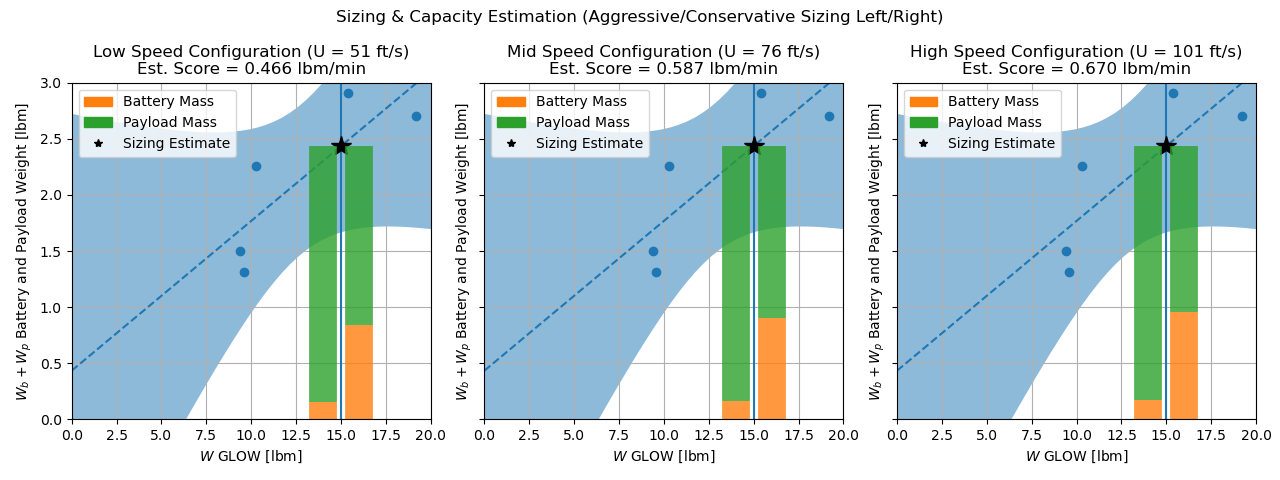

In [27]:
fig, ax = plt.subplots(1,3, figsize=(12.8, 4.8), sharex=True, sharey=True)
ax[0].plot(m_data / consts.lb, mp_mb_data / consts.lb, 'o')
ax[0].fill_between(m_range  / consts.lb, pred['mean_ci_lower']  / consts.lb, pred['mean_ci_upper']  / consts.lb, alpha=0.5)
ax[0].plot(m_range  / consts.lb, pred['mean']  / consts.lb, "C0--")
ax[1].plot(m_data  / consts.lb, mp_mb_data  / consts.lb, 'o')
ax[1].fill_between(m_range / consts.lb, pred['mean_ci_lower'] / consts.lb, pred['mean_ci_upper'] / consts.lb, alpha=0.5)
ax[1].plot(m_range / consts.lb, pred['mean'] / consts.lb, "C0--")
ax[2].plot(m_data / consts.lb, mp_mb_data / consts.lb, 'o')
ax[2].fill_between(m_range / consts.lb, pred['mean_ci_lower'] / consts.lb, pred['mean_ci_upper'] / consts.lb, alpha=0.5)
ax[2].plot(m_range / consts.lb, pred['mean'] / consts.lb, "C0--")

ax[0].axvline(max_GLOM  / consts.lb)
ax[0].plot(max_GLOM  / consts.lb, mp_mb_mean  / consts.lb, "k*", markersize=15)
ax[0].vlines(max_GLOM  / consts.lb + 1, 0, mb_conserv_low  / consts.lb, linewidths=20, colors="C1", alpha=0.8)
ax[0].vlines(max_GLOM  / consts.lb - 1, 0, mb_aggr_low  / consts.lb, linewidths=20, colors="C1", alpha=0.8)
ax[0].vlines(max_GLOM  / consts.lb + 1, mb_conserv_low  / consts.lb, mp_mb_mean  / consts.lb, linewidths=20, colors="C2", alpha=0.8)
ax[0].vlines(max_GLOM  / consts.lb - 1, mb_aggr_low  / consts.lb, mp_mb_mean  / consts.lb, linewidths=20, colors="C2", alpha=0.8)

ax[1].axvline(max_GLOM / consts.lb)
ax[1].plot(max_GLOM / consts.lb, mp_mb_mean / consts.lb, "k*", markersize=15)
ax[1].vlines(max_GLOM / consts.lb + 1, 0, mb_conserv_mid / consts.lb, linewidths=20, colors="C1", alpha=0.8)
ax[1].vlines(max_GLOM / consts.lb - 1, 0, mb_aggr_mid / consts.lb, linewidths=20, colors="C1", alpha=0.8)
ax[1].vlines(max_GLOM / consts.lb + 1, mb_conserv_mid / consts.lb, mp_mb_mean / consts.lb, linewidths=20, colors="C2", alpha=0.8)
ax[1].vlines(max_GLOM / consts.lb - 1, mb_aggr_mid / consts.lb, mp_mb_mean / consts.lb, linewidths=20, colors="C2", alpha=0.8)

ax[2].axvline(max_GLOM / consts.lb)
ax[2].plot(max_GLOM / consts.lb, mp_mb_mean / consts.lb, "k*", markersize=15)
ax[2].vlines(max_GLOM / consts.lb + 1, 0, mb_conserv_high / consts.lb, linewidths=20, colors="C1", alpha=0.8)
ax[2].vlines(max_GLOM / consts.lb - 1, 0, mb_aggr_high / consts.lb, linewidths=20, colors="C1", alpha=0.8)
ax[2].vlines(max_GLOM / consts.lb + 1, mb_conserv_high / consts.lb, mp_mb_mean / consts.lb, linewidths=20, colors="C2", alpha=0.8)
ax[2].vlines(max_GLOM / consts.lb - 1, mb_aggr_high / consts.lb, mp_mb_mean / consts.lb, linewidths=20, colors="C2", alpha=0.8)

ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 3)
# ax.set_aspect("equal")
ax[0].set_xlabel("$W$ GLOW [lbm]")
ax[0].set_ylabel("$W_b + W_p$ Battery and Payload Weight [lbm]")
ax[1].set_xlabel("$W$ GLOW [lbm]")
ax[1].set_ylabel("$W_b + W_p$ Battery and Payload Weight [lbm]")
ax[2].set_xlabel("$W$ GLOW [lbm]")
ax[2].set_ylabel("$W_b + W_p$ Battery and Payload Weight [lbm]")
ax[0].set_title(f"Low Speed Configuration (U = {v_cruise_low / consts.foot:.0f} ft/s)\nEst. Score = {score_conserv_low / consts.lb * consts.minute:.3f} lbm/min")
ax[1].set_title(f"Mid Speed Configuration (U = {v_cruise_mid / consts.foot:.0f} ft/s)\nEst. Score = {score_conserv_mid / consts.lb * consts.minute:.3f} lbm/min")
ax[2].set_title(f"High Speed Configuration (U = {v_cruise_high / consts.foot:.0f} ft/s)\nEst. Score = {score_conserv_high / consts.lb * consts.minute:.3f} lbm/min")
fig.suptitle("Sizing & Capacity Estimation (Aggressive/Conservative Sizing Left/Right)")
legend_lines = [
    patches.Patch(color='C1', label="Battery Mass"),
    patches.Patch(color='C2', label="Payload Mass"),
    plt.Line2D([], [], ls="", marker="*", color="k", label="Sizing Estimate")
]
ax[0].legend(handles=legend_lines, loc="upper left")
ax[1].legend(handles=legend_lines, loc="upper left")
ax[2].legend(handles=legend_lines, loc="upper left")
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.tight_layout()
fig.savefig("Sizing.png", dpi=300)